In [21]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
from scipy import stats
import time
import datetime

import poloniex

In [12]:
sns.set_style('whitegrid')

In [2]:
polo = poloniex.Poloniex()
period = polo.DAY # period of data
end = time.time()
start = end - period * 365 # 1 year

btc = polo.returnChartData('USDT_BTC', period=period, start=start, end=end)
eth = polo.returnChartData('USDT_ETH', period=period, start=start, end=end)

In [3]:
btc = DataFrame.from_dict(btc)
eth = DataFrame.from_dict(eth)

timestamp = btc['date'].values.tolist() # Series -> ndarray -> list
# timestamp -> year/month/day
date = [datetime.datetime.fromtimestamp(timestamp[i]).date() for i in range(len(timestamp))]

btc = btc.astype(float)
eth = eth.astype(float)

btc['date'] = date
btc['timestamp'] = timestamp
eth['date'] = date
eth['timestamp'] = timestamp
btc.head()

,date,high,low,open,close,volume,quoteVolume,weightedAverage,timestamp
0,2020-04-23,7553.060485,7553.060485,7553.060485,7553.060485,0.000000e+00,0.000000,7553.060485,1587620518
1,2020-04-24,7605.555556,7397.041200,7551.384364,7502.897565,1.641349e+07,2183.247717,7517.924269,1587686400
2,2020-04-25,7696.659932,7439.124738,7503.323928,7538.715711,1.665867e+07,2208.694648,7542.313014,1587772800
3,2020-04-26,7700.000000,7483.682284,7538.715711,7694.626301,1.703245e+07,2242.789247,7594.317541,1587859200
4,2020-04-27,7788.000000,7624.601700,7694.754048,7773.240743,2.421146e+07,3143.131254,7702.975600,1587945600


In [4]:
eth.head()

,date,high,low,open,close,volume,quoteVolume,weightedAverage,timestamp
0,2020-04-23,188.802303,188.802303,188.802303,188.802303,0.000000e+00,0.000000,188.802303,1587620518
1,2020-04-24,189.700825,184.595200,188.744122,187.449717,4.126043e+06,22016.484346,187.407003,1587686400
2,2020-04-25,198.000000,185.874566,187.615879,194.288233,5.715689e+06,29505.495291,193.716096,1587772800
3,2020-04-26,199.798207,192.370587,194.130324,197.517808,5.710684e+06,29234.794477,195.338612,1587859200
4,2020-04-27,199.000000,189.358385,197.516808,196.431188,4.868896e+06,25027.889450,194.538829,1587945600


In [5]:
btc.drop(['quoteVolume', 'weightedAverage'], axis=1, inplace=True)
eth.drop(['quoteVolume', 'weightedAverage'], axis=1, inplace=True)

In [6]:
for df in [btc, eth]:
    df['EMA20'] = df['open'].ewm(span=20).mean()
    df['SMA50'] = df['open'].rolling(window=50).mean()
btc.head()

,date,high,low,open,close,volume,timestamp,EMA20,SMA50
0,2020-04-23,7553.060485,7553.060485,7553.060485,7553.060485,0.000000e+00,1587620518,7553.060485,NaN
1,2020-04-24,7605.555556,7397.041200,7551.384364,7502.897565,1.641349e+07,1587686400,7552.180522,NaN
2,2020-04-25,7696.659932,7439.124738,7503.323928,7538.715711,1.665867e+07,1587772800,7534.240674,NaN
3,2020-04-26,7700.000000,7483.682284,7538.715711,7694.626301,1.703245e+07,1587859200,7535.532548,NaN
4,2020-04-27,7788.000000,7624.601700,7694.754048,7773.240743,2.421146e+07,1587945600,7574.046874,NaN


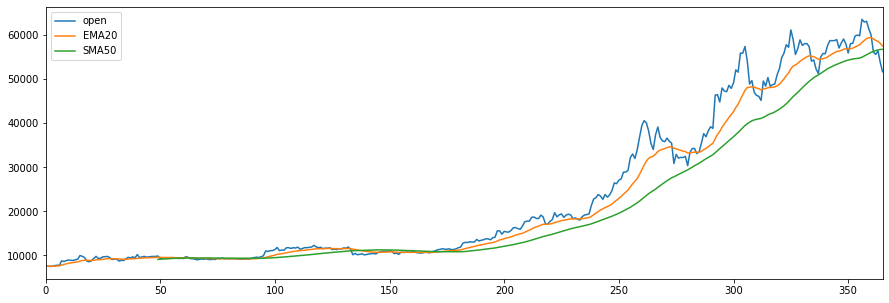

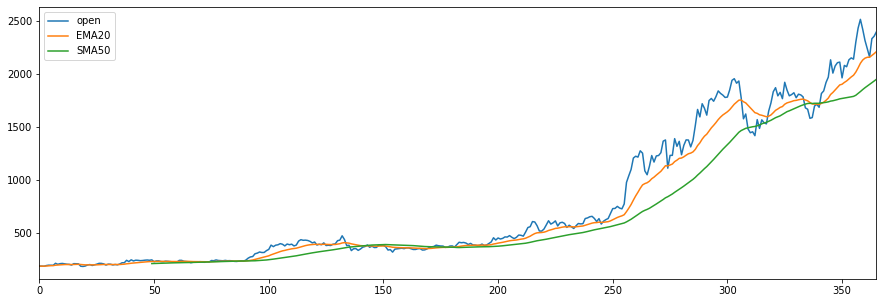

In [7]:
for df in [btc, eth]:
    df[['open', 'EMA20', 'SMA50']].plot(subplots=False, figsize=(15, 5))

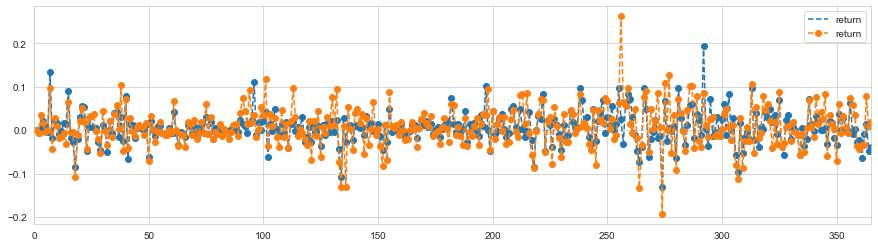

In [15]:
for df in [btc, eth]:
    df['return'] = df['open'].pct_change()
    df['return'].plot(figsize=(15,4), legend=True, linestyle='--', marker='o')

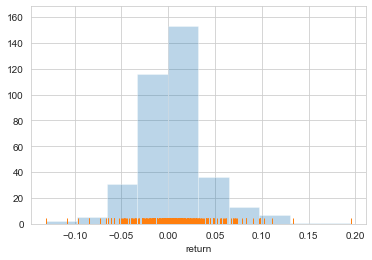

In [18]:
plt.hist(btc['return'], alpha=.3)
sns.rugplot(btc['return'])

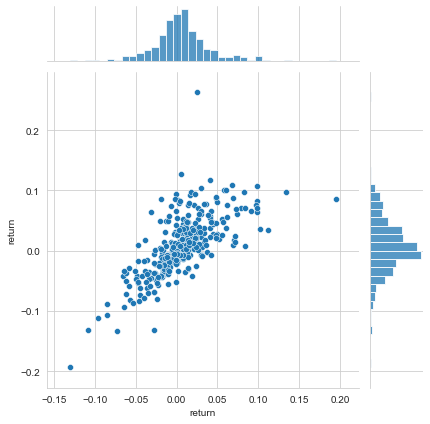

In [19]:
sns.jointplot(x=btc['return'], y=eth['return'])

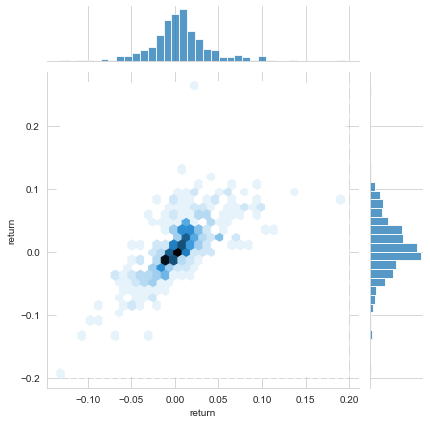

In [20]:
sns.jointplot(x=btc['return'], y=eth['return'], kind='hex')

## カーネル密度推定

(0, 0.5)

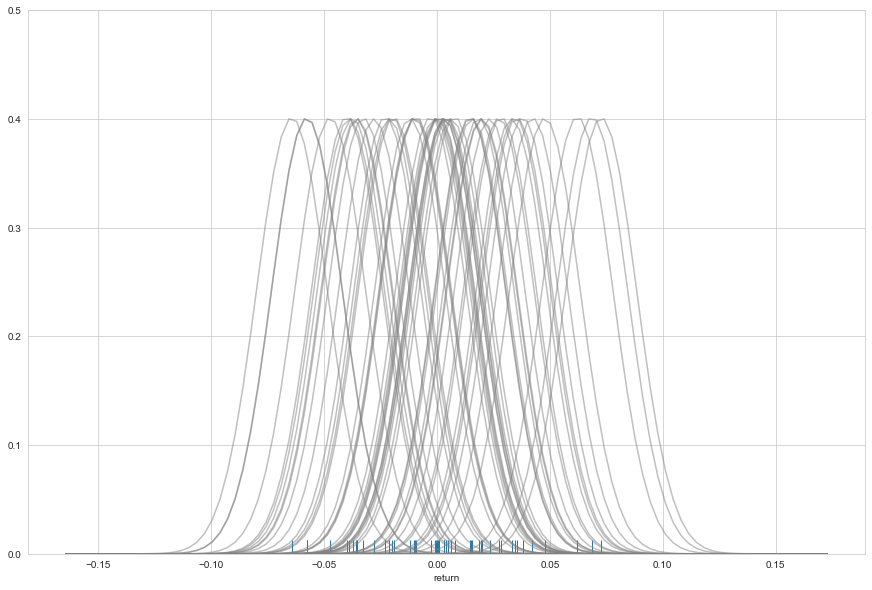

In [29]:
data = btc['return'].tail(50)

plt.figure(figsize=(15, 10))
sns.rugplot(data)

x_min = data.min() - 0.1
x_max = data.max() + 0.1
x_axis = np.linspace(x_min, x_max, 100)

bandwidth = ((4*data.std()**5)/(3*len(data)))**0.2

kernel_list = []
for point in data:
    kernel = stats.norm(point, bandwidth).pdf(x_axis)
    kernel_list.append(kernel)
    
    kernel /= kernel.max()
    kernel *= 0.4
    
    plt.plot(x_axis, kernel, color='gray', alpha=.5)
plt.ylim(0, 0.5)

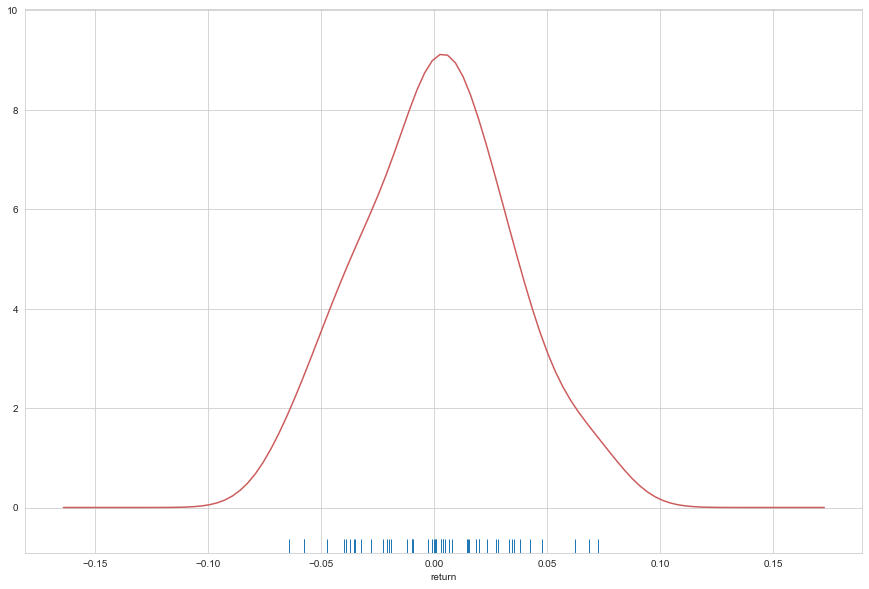

In [30]:
sum_kde = np.sum(kernel_list, axis=0)

plt.figure(figsize=(15, 10))
fig = plt.plot(x_axis, sum_kde, color='indianred')
sns.rugplot(data)

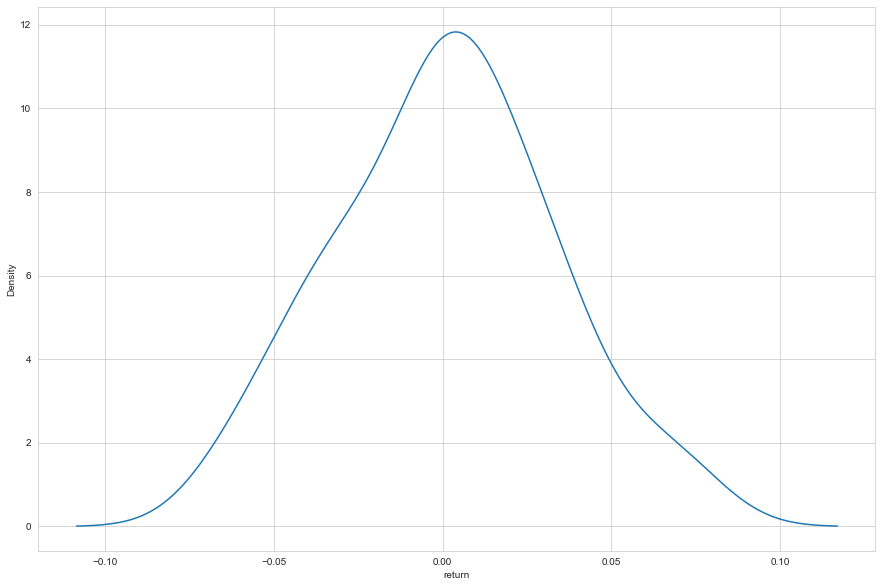

In [34]:
plt.figure(figsize=(15, 10))
sns.kdeplot(data)

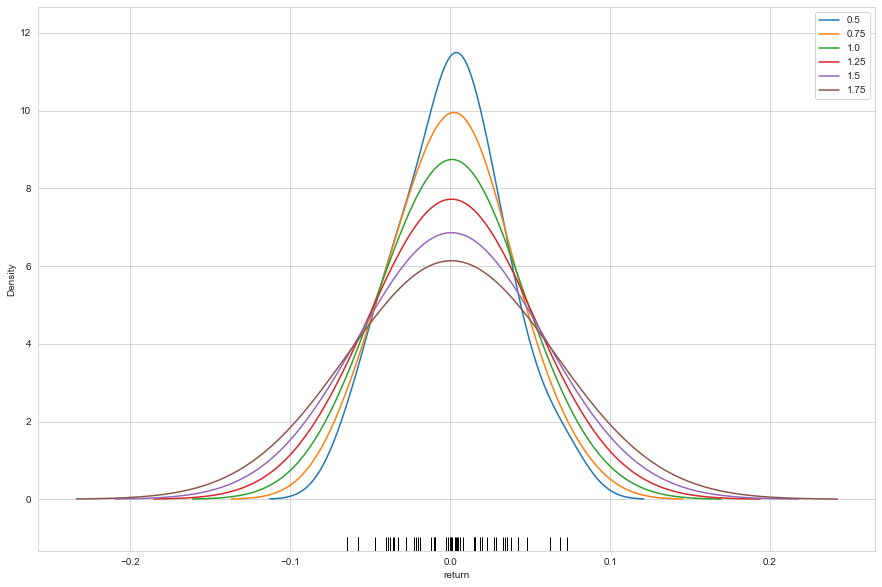

In [36]:
plt.figure(figsize=(15, 10))
sns.rugplot(data, c='black')
for bw in np.arange(0.5, 2, 0.25):
    sns.kdeplot(data, bw_method=bw, label=bw)
plt.legend()

(array([ 3.,  7., 11., 18., 29., 35., 41., 46., 47., 50.]),
 array([-0.06420469, -0.05050788, -0.03681108, -0.02311428, -0.00941747,
         0.00427933,  0.01797613,  0.03167294,  0.04536974,  0.05906654,
         0.07276335]),
 <a list of 10 Patch objects>)

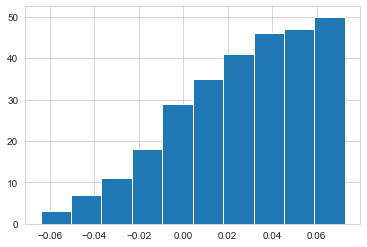

In [38]:
plt.hist(data, cumulative=True)

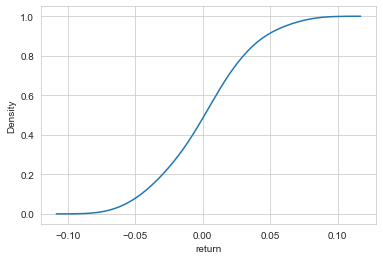

In [41]:
sns.kdeplot(data, cumulative=True)

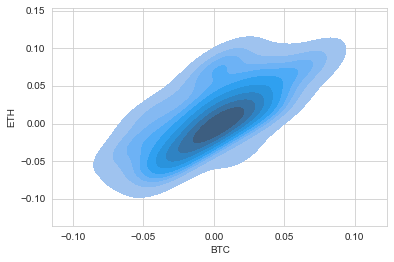

In [63]:
df = pd.concat([btc['return'], eth['return']], axis=1).tail(50)
df.columns = ['BTC', 'ETH']
sns.kdeplot(x=df.BTC, y=df.ETH, shade=True)

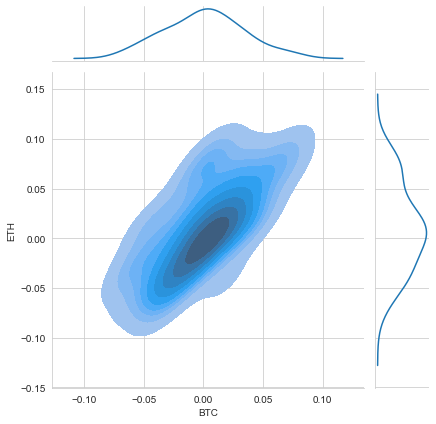

In [64]:
sns.jointplot(x='BTC', y='ETH', data=df, kind='kde', shade=True)

C:\Users\Kodai Tokieda\Anaconda3\envs\lab_gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Kodai Tokieda\Anaconda3\envs\lab_gpu\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


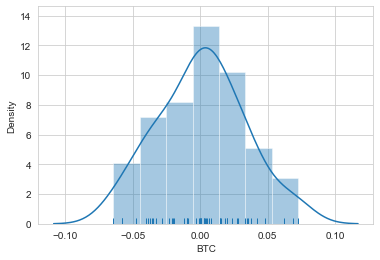

In [69]:
sns.distplot(df.BTC, rug=True)